In [1]:
ALPH = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"

In [2]:
import random, math, numpy as np, pandas as pd, matplotlib.pyplot as plt
from collections import Counter
# from caas_jupyter_tools import #display_dataframe_to_user

# If sympy is needed for Hill:
try:
    from sympy import Matrix
except Exception:
    Matrix = None

# ----------------------------
# Shared metric functions
# ----------------------------
_eps = 1e-12
def _entropy_from_counts(counts, base=2):
    total = sum(counts.values())
    if total == 0: return 0.0
    H = 0.0
    for v in counts.values():
        p = v/total
        if p>0:
            H -= p * math.log(p, base)
    return H

def jensen_shannon_divergence(p_counts, q_counts, base=2):
    all_keys = set(p_counts.keys()) | set(q_counts.keys())
    Np, Nq = sum(p_counts.values()) or 1, sum(q_counts.values()) or 1
    m = {}
    for k in all_keys:
        m[k] = (p_counts.get(k,0)/Np + q_counts.get(k,0)/Nq) / 2.0
    kl_pm = 0.0; kl_qm = 0.0
    for k in all_keys:
        p = p_counts.get(k,0)/Np; q = q_counts.get(k,0)/Nq; mm = m[k]
        if p>0: kl_pm += p * math.log((p+_eps)/(mm+_eps), base)
        if q>0: kl_qm += q * math.log((q+_eps)/(mm+_eps), base)
    return 0.5*(kl_pm+kl_qm)

def mutual_information_pairs(pairs, base=2):
    N = len(pairs)
    if N==0: return 0.0
    joint = Counter(pairs)
    X = Counter(x for x,_ in pairs); Y = Counter(y for _,y in pairs)
    mi = 0.0
    for (x,y),n in joint.items():
        p_xy = n/N; p_x = X[x]/N; p_y = Y[y]/N
        mi += p_xy * math.log((p_xy+_eps)/(p_x*p_y+_eps), base)
    return mi

def confusion_jsd_avg(cipher_fun, plaintext, keyspace, sample_pairs=200, base=2):
    if len(keyspace) < 2: return 0.0
    total = 0.0; count = 0
    # If keyspace small, enumerate pairs; else sample
    for _ in range(sample_pairs):
        k1, k2 = random.sample(keyspace, 2)
        c1 = cipher_fun(plaintext, k1)
        c2 = cipher_fun(plaintext, k2)
        total += jensen_shannon_divergence(Counter(c1), Counter(c2), base=base)
        count += 1
    return total/count if count else 0.0

def diffusion_via_bigram_leakage(cipher_fun, plaintext, key, base=2):
    pt = "".join(ch for ch in plaintext.upper() if ch.isalnum())
    grams = [pt[i:i+2] for i in range(len(pt)-1)]
    if not grams:
        return 0.0
    C = cipher_fun(pt, key)
    L = min(len(grams), len(C))
    pairs = [(grams[i], C[i]) for i in range(L)]
    mi = mutual_information_pairs(pairs, base=base)
    H = _entropy_from_counts(Counter(grams), base=base)
    return 1.0 - (mi / H if H > 0 else 0.0)

def cdci_linear(alpha, C, D): return alpha*C + (1.0-alpha)*D

def compute_cdci_for_cipher(cipher_func, plaintexts, fixed_key, keyspace, alpha=0.5, sample_pairs=200):
    Cs = []; Ds = []
    for pt in plaintexts:
        C_val = confusion_jsd_avg(cipher_func, pt, keyspace, sample_pairs=sample_pairs)
        D_val = diffusion_via_bigram_leakage(cipher_func, pt, fixed_key)
        Cs.append(C_val); Ds.append(D_val)
    C_mean = float(np.mean(Cs)); D_mean = float(np.mean(Ds))
    return {'C':C_mean, 'D':D_mean, 'CDCI': cdci_linear(alpha, C_mean, D_mean), 'C_per_plain': Cs, 'D_per_plain': Ds}

# Generic helper metrics reused in each block
def fraction_changed(a, b):
    L = min(len(a), len(b))
    return sum(x!=y for x,y in zip(a[:L], b[:L])) / L if L else 0.0

def symbol_diffusion_index(cipher_func, plaintext, key, alphabet, trials=20):
    base_ct = cipher_func(plaintext, key)
    results = []
    pt_filtered = "".join(ch for ch in plaintext.upper() if ch.isalnum())
    if len(pt_filtered) == 0:
        return 0.0, 0.0
    for _ in range(trials):
        i = random.randrange(len(pt_filtered))
        new_char = random.choice([c for c in alphabet if c != pt_filtered[i]])
        P2 = pt_filtered[:i] + new_char + pt_filtered[i+1:]
        C2 = cipher_func(P2, key)
        results.append(fraction_changed(base_ct, C2))
    return float(np.mean(results)), float(np.std(results)) if len(results)>1 else 0.0

def compute_ksi(cipher_func, plaintext, key, key_variant):
    C1 = cipher_func(plaintext, key)
    C2 = cipher_func(plaintext, key_variant)
    return fraction_changed(C1, C2)

def compute_mi_from_plain_cipher_lists(plain_list, cipher_list):
    conc_plain = "".join( "".join(ch for ch in p.upper() if ch.isalnum()) for p in plain_list )
    conc_cipher = "".join(cipher_list)
    L = min(len(conc_plain), len(conc_cipher))
    pairs = list(zip(conc_plain[:L], conc_cipher[:L]))
    return mutual_information_pairs(pairs)

def compute_chi_entropy(ciphertexts, alphabet):
    text = "".join(ciphertexts)
    N = len(text)
    if N == 0: return 0.0, 0.0
    counts = Counter(text)
    expected = N / len(alphabet)
    chi2 = sum((counts[a] - expected)**2 / expected for a in alphabet)
    entropy = -sum((counts[a]/N) * math.log2(counts[a]/N) for a in counts if counts[a]>0)
    return chi2, entropy

def bootstrap_mi(pairs, n_boot=300, alpha=0.05):
    N = len(pairs)
    if N == 0: return 0.0, (0.0, 0.0)
    estimates = []
    for _ in range(n_boot):
        sample = [pairs[random.randrange(N)] for _ in range(N)]
        estimates.append(mutual_information_pairs(sample))
    estimates.sort()
    low = estimates[int((alpha/2)*n_boot)]
    high = estimates[int((1-alpha/2)*n_boot)]
    return np.mean(estimates), (low, high)

In [3]:
# ----------------------------
# 3) Vigenere cipher
# ----------------------------
def vigenere_encrypt(text, key):
    txt = "".join(ch for ch in text.upper() if 'A' <= ch <= 'Z')
    key = key.upper()
    out = []
    for i,ch in enumerate(txt):
        shift = ord(key[i % len(key)]) - 65
        out.append(chr(((ord(ch)-65 + shift) % 26) + 65))
    return "".join(out)

def random_vigenere_key(min_len=3, max_len=7):
    return "".join(random.choice(ALPH) for _ in range(random.randint(min_len, max_len)))

def perturb_vigenere_key(key):
    pos = random.randrange(len(key)); new_char = random.choice([c for c in ALPH if c!=key[pos]])
    return key[:pos] + new_char + key[pos+1:]

def evaluate_vigenere(num_texts=5, length=200, fixed_key="KEY", random_key_count=10, alpha=0.5):
    plaintexts = [ "".join(random.choice(ALPH) for _ in range(length)) for _ in range(num_texts) ]
    plaintexts[0] = ("It is a truth universally acknowledged that a single man in possession of a good fortune must be in want of a wife However little known the feelings or views of such a man may be on his first entering a neighbourhood this truth is so well fixed in the minds of the surrounding families that he is considered the rightful property of some one or other of their daughters My dear Mr Bennet said his lady to him one day have you heard that Netherfield Park is let at last Mr Bennet replied that he had not But it is returned she for Mrs Long has just been here and she told me all about it Mr Bennet made no answer Do not you want to know who has taken it Cried his wife impatiently You want to tell me and I have no objection to hearing it This was invitation enough Why my dear you must know Mrs Long says that Netherfield is taken by a young man of large fortune from the north of England What is his name" * 6)[:length]
    keyspace = [random_vigenere_key() for _ in range(120)]

    fixed_metrics = {}
    sdi_vals=[]; ksi_vals=[]; mi_vals=[]; chi_vals=[]; ent_vals=[]; mi_boot=[]
    for pt in plaintexts:
        sm,ss = symbol_diffusion_index(vigenere_encrypt, pt, fixed_key, ALPH)
        sdi_vals.append(sm); ksi_vals.append(compute_ksi(vigenere_encrypt, pt, fixed_key, perturb_vigenere_key(fixed_key)))
        C = vigenere_encrypt(pt, fixed_key)
        mi_vals.append(compute_mi_from_plain_cipher_lists([pt],[C])); chi,H = compute_chi_entropy([C], ALPH)
        chi_vals.append(chi); ent_vals.append(H)
        mb,ci = bootstrap_mi(list(zip("".join(ch for ch in pt.upper() if ch.isalnum()), C[:len(pt)])), n_boot=150)
        mi_boot.append(mb)
    cdci_out = compute_cdci_for_cipher(vigenere_encrypt, plaintexts, fixed_key, keyspace, alpha=alpha)
    fixed_metrics.update({
        'SDI_mean': np.mean(sdi_vals), 'KSI_mean': np.mean(ksi_vals), 'MI_mean': np.mean(mi_vals),
        'Chi2_mean': np.mean(chi_vals), 'Entropy_mean': np.mean(ent_vals), 'MI_boot_mean': np.mean(mi_boot),
        'C': cdci_out['C'], 'D': cdci_out['D'], 'CDCI': cdci_out['CDCI']
    })
    fixed_df = pd.DataFrame([fixed_metrics])

    random_keys = [random_vigenere_key() for _ in range(random_key_count)]
    rand_records=[]
    for rk in random_keys:
        sdi_vals=[]; ksi_vals=[]; mi_vals=[]; chi_vals=[]; ent_vals=[]; mi_boot=[]
        for pt in plaintexts:
            sm,ss = symbol_diffusion_index(vigenere_encrypt, pt, rk, ALPH)
            sdi_vals.append(sm); ksi_vals.append(compute_ksi(vigenere_encrypt, pt, rk, perturb_vigenere_key(rk)))
            C = vigenere_encrypt(pt, rk)
            mi_vals.append(compute_mi_from_plain_cipher_lists([pt],[C])); chi,H = compute_chi_entropy([C], ALPH)
            chi_vals.append(chi); ent_vals.append(H)
            mb,_ = bootstrap_mi(list(zip("".join(ch for ch in pt.upper() if ch.isalnum()), C[:len(pt)])), n_boot=120)
            mi_boot.append(mb)
        cdci_out = compute_cdci_for_cipher(vigenere_encrypt, plaintexts, rk, keyspace, alpha=alpha)
        rand_records.append({
            'key': rk, 'SDI_mean': np.mean(sdi_vals), 'KSI_mean': np.mean(ksi_vals),
            'MI_mean': np.mean(mi_vals), 'Chi2_mean': np.mean(chi_vals), 'Entropy_mean': np.mean(ent_vals),
            'MI_boot_mean': np.mean(mi_boot), 'C': cdci_out['C'], 'D': cdci_out['D'], 'CDCI': cdci_out['CDCI']
        })
    random_df = pd.DataFrame(rand_records)
    summary = pd.DataFrame({
        'mode':['fixed','random_mean'],
        'SDI_mean':[fixed_metrics['SDI_mean'], random_df['SDI_mean'].mean()],
        'KSI_mean':[fixed_metrics['KSI_mean'], random_df['KSI_mean'].mean()],
        'MI_mean':[fixed_metrics['MI_mean'], random_df['MI_mean'].mean()],
        'Entropy_mean':[fixed_metrics['Entropy_mean'], random_df['Entropy_mean'].mean()],
        'CDCI':[fixed_metrics['CDCI'], random_df['CDCI'].mean()],
        'C_index':[fixed_metrics['C'], random_df['C'].mean()],
        'D_index':[fixed_metrics['D'], random_df['D'].mean()]
    })

    #display_dataframe_to_user("Vigenere - Fixed", fixed_df)
    #display_dataframe_to_user("Vigenere - Random", random_df)
    #display_dataframe_to_user("Vigenere - Summary", summary)

    # plots
    x = np.arange(len(summary)); width=0.25
    fig, ax = plt.subplots(figsize=(7,4))
    ax.bar(x-width, summary['CDCI'], width, label='CDCI')
    ax.bar(x, summary['C_index'], width, label='C-index')
    ax.bar(x+width, summary['D_index'], width, label='D-index')
    ax.set_xticks(x); ax.set_xticklabels(summary['mode']); ax.set_ylabel('Score'); ax.set_title('Vigenere: CDCI / C / D'); ax.legend(); plt.show()

    # fixed_df.to_csv('../mnt/data/vigenere_fixed.csv', index=False)
    # random_df.to_csv('../mnt/data/vigenere_random.csv', index=False)
    # summary.to_csv('../mnt/data/vigenere_summary.csv', index=False)
    print("Vigenere saved to ./mnt/data/vigenere_*.csv")
    return fixed_df, random_df, summary

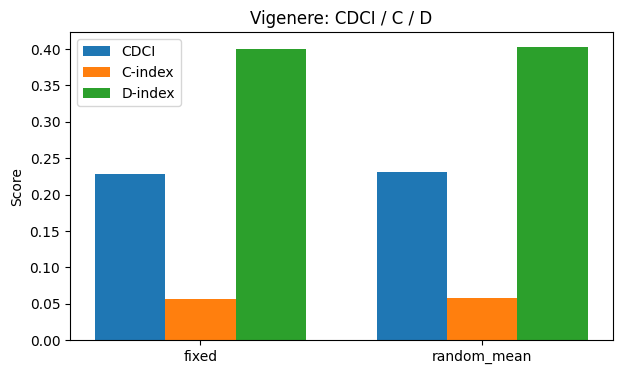

Vigenere saved to ./mnt/data/vigenere_*.csv


(   SDI_mean  KSI_mean  MI_mean  Chi2_mean  Entropy_mean  MI_boot_mean  \
 0  0.005242  0.335081  3.17399  29.562882      4.570363      3.274471   
 
           C         D      CDCI  
 0  0.056594  0.400296  0.228445  ,
        key  SDI_mean  KSI_mean   MI_mean  Chi2_mean  Entropy_mean  \
 0      ANT  0.005242  0.334081  3.185059  28.923379      4.581432   
 1  ZJBSEHY  0.005242  0.144571  2.442195  31.117714      4.584314   
 2   IKPVIC  0.005242  0.165540  2.757788  32.038857      4.573088   
 3     OYBT  0.005242  0.249689  2.931955  32.265913      4.573218   
 4     QDNV  0.005242  0.249689  2.928613  33.086932      4.569876   
 5  EEZAWDM  0.005242  0.141571  2.635361  25.834062      4.600079   
 6  UXSIARC  0.005242  0.143571  2.440975  30.427180      4.583094   
 7     PTRM  0.005242  0.249689  2.946241  27.688298      4.587504   
 8     EKXG  0.005242  0.249689  2.915499  37.528571      4.556762   
 9      KDF  0.005242  0.335081  3.184703  28.022584      4.581076   
 
    MI_

In [4]:
evaluate_vigenere()